In [1]:
import pandas as pd
import xgboost
import shap
import RDG_interventional
import RDG_gaussian
import numpy as np
import random
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.model_selection import train_test_split

In [2]:
X = shap.datasets.independentlinear60()
#X = (X - np.min(X))/(np.max(X)-np.min(X))
#y =  (y - np.min(y))/(np.max(y)-np.min(y))

In [3]:
y = X[1]
X = X[0]
X = (X - np.min(X))/(np.max(X)-np.min(X))
y =  (y - np.min(y))/(np.max(y)-np.min(y))

In a future version, DataFrame.min(axis=None) will return a scalar min over the entire DataFrame. To retain the old behavior, use 'frame.min(axis=0)' or just 'frame.min()'
In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'


In [52]:
X.shape

(1000, 60)

In [5]:
feature_names = np.arange(X.shape[1])

In [6]:
feature_names

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59])

In [7]:
correlation_matrix = pd.DataFrame(X).corr().round(2)
correlation_matrix

,0,1,2,3,4,5,6,7,8,9,...,50,51,52,53,54,55,56,57,58,59
0,1.00,0.02,0.00,0.00,-0.03,-0.01,0.04,0.03,0.04,0.01,...,-0.01,0.00,-0.01,-0.00,0.03,-0.05,0.01,0.05,-0.03,-0.04
1,0.02,1.00,0.04,-0.01,-0.05,-0.00,0.02,-0.06,-0.02,-0.05,...,-0.01,-0.00,-0.05,0.03,-0.00,0.03,-0.00,-0.02,0.01,0.00
2,0.00,0.04,1.00,-0.05,-0.01,-0.00,0.03,0.03,-0.06,-0.04,...,-0.07,0.01,-0.03,-0.01,-0.03,-0.06,-0.03,0.02,0.01,-0.04
3,0.00,-0.01,-0.05,1.00,-0.05,0.00,-0.08,0.02,-0.01,0.03,...,0.03,0.03,0.02,-0.02,-0.01,-0.00,-0.02,-0.01,-0.04,0.04
4,-0.03,-0.05,-0.01,-0.05,1.00,-0.02,-0.05,-0.02,-0.04,-0.01,...,0.00,-0.05,-0.01,-0.01,-0.00,-0.03,0.02,-0.01,-0.02,-0.01
5,-0.01,-0.00,-0.00,0.00,-0.02,1.00,-0.06,-0.04,0.01,-0.03,...,-0.01,0.01,-0.08,-0.02,-0.01,0.02,0.03,0.00,0.02,0.01
6,0.04,0.02,0.03,-0.08,-0.05,-0.06,1.00,0.00,-0.06,-0.02,...,0.01,0.01,-0.02,0.03,0.02,0.01,0.04,0.04,0.02,-0.03
7,0.03,-0.06,0.03,0.02,-0.02,-0.04,0.00,1.00,-0.00,0.04,...,0.03,0.00,-0.04,-0.01,-0.05,0.00,-0.01,0.02,0.01,-0.02
8,0.04,-0.02,-0.06,-0.01,-0.04,0.01,-0.06,-0.00,1.00,-0.05,...,0.08,-0.01,-0.01,0.01,0.01,0.08,0.02,-0.02,0.00,0.03
9,0.01,-0.05,-0.04,0.03,-0.01,-0.03,-0.02,0.04,-0.05,1.00,...,-0.04,-0.04,-0.03,-0.06,-0.01,0.00,-0.01,-0.02,0.00,0.03


In [8]:
X = X.values

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
clf = GradientBoostingRegressor(n_estimators=1000, learning_rate=0.1,max_depth=3, random_state=0).fit(X_train, y_train)
from sklearn.ensemble import RandomForestRegressor
#clf = RandomForestRegressor(max_depth=100, random_state=0).fit(X_train, y_train)
print(clf.score(X_test, y_test))

cov = np.cov(X.T)
means = X.mean(axis=0)

minis = np.min(X,axis=0)
maxis = np.max(X,axis=0)

0.8693966687033665


ground_truth = {}
for i in range(0,len(clf.coef_[0])):
    ground_truth[i] = np.abs(clf.coef_[0][i])
sorted_indexes = sorted(ground_truth, key=ground_truth.get,reverse=True)
sorted_indexes

In [10]:
explainer = shap.Explainer(clf)
og_shap_values = explainer(X_test)

In [11]:
e = shap.KernelExplainer(clf.predict, X_train[0:10])
ks_shap_values = e.shap_values(X_test[0:1000])

  0%|          | 0/330 [00:00<?, ?it/s]

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

In [53]:
overall_ss_g_sum_indexes = []
overall_ss_i_sum_indexes = []
overall_ks_sum_indexes = []
overall_og_sum_indexes = []
overall_tree_sum_indexes = []

overall_ss_g_indexes = []
overall_ss_i_indexes = []
overall_ks_indexes = []
overall_og_indexes = []
overall_tree_indexes = []

ss_g_scores = []
ss_i_scores = []
ks_scores = []
og_scores = []
#tree_scores = []
for a in range(0,3):
    x = X_test[a]
    ss_i_atts,seps,nonseps = RDG_interventional.RDG(clf.predict,x,means,minis,maxis,0.05)
    ss_g_atts,seps,nonseps = RDG_gaussian.RDG(clf.predict,x,means,cov,minis,maxis,0.01,X)
    
    ks_atts = {}
    for val in range(0,len(ks_shap_values[a])):
        ks_atts[val] = ks_shap_values[a][val]
    
    og_atts = {}
    for val in range(0,len(og_shap_values[a].values)):
        og_atts[val] = og_shap_values[a].values[val]
        
    #tree_atts = {}
    #for val in range(0,len(tree_shap_values[a])):
        #tree_atts[val] = tree_shap_values[a][val]

    temp = {}
    for u in ss_i_atts.keys():
        temp[u] = np.abs(ss_i_atts[u])
    sorted_ss_i_indexes = sorted(temp, key=temp.get, reverse=True)
    
    temp = {}
    for u in ss_g_atts.keys():
        temp[u] = np.abs(ss_g_atts[u]) 
    sorted_ss_g_indexes = sorted(temp, key=temp.get, reverse=True)
    
    temp = {}
    for u in ks_atts.keys():
        temp[u] = np.abs(ks_atts[u]) 
    sorted_ks_indexes = sorted(temp, key=temp.get, reverse=True)
    
    temp = {}
    for u in og_atts.keys():
        temp[u] = np.abs(og_atts[u]) 
    sorted_og_indexes = sorted(temp, key=temp.get, reverse=True)
    
    #temp = {}
    #for u in tree_atts.keys():
       # temp[u] = np.abs(tree_atts[u]) 
    #sorted_tree_indexes = sorted(temp, key=temp.get, reverse=True)
    
    overall_ss_g_indexes.append(sorted_ss_g_indexes[0])
    overall_ss_i_indexes.append(sorted_ss_i_indexes[0])
    overall_ks_indexes.append(sorted_ks_indexes[0])
    overall_og_indexes.append(sorted_og_indexes[0])
    #overall_tree_indexes.append(sorted_tree_indexes[0])
    
    total_sum = clf.predict(x.reshape(1,-1))[0] -  clf.predict(means.reshape(1,-1))[0]

    overall_ss_i_sum_indexes.append(sum(ss_i_atts.values())[0] - total_sum)
    overall_ss_g_sum_indexes.append(sum(ss_g_atts.values())[0] - total_sum)
    overall_ks_sum_indexes.append(sum(ks_atts.values()) - total_sum)
    overall_og_sum_indexes.append(sum(og_atts.values()) - total_sum)
    
    
    ind = sorted_ss_g_indexes[0]
    new_x = x.copy()
    if len(list(ind)) > 1:
        for u in list(ind):
            new_x[u] = means[u]
    else:
        new_x[list(ind)[0]] = means[list(ind)[0]]
    
    prediction = clf.predict(new_x.reshape(1,-1))
    
    ss_g_scores.append(np.abs(prediction - clf.predict(means.reshape(1,-1))))
    
    ind = sorted_ss_i_indexes[0]
    new_x = x.copy()
    if len(list(ind)) > 1:
        for u in list(ind):
            new_x[u] = means[u]
    else:
        new_x[list(ind)[0]] = means[list(ind)[0]]
    
    prediction = clf.predict(new_x.reshape(1,-1))
    
    ss_i_scores.append(np.abs(prediction - clf.predict(means.reshape(1,-1))))
    
    ind = sorted_ks_indexes[0]
    new_x = x.copy()
    
    new_x[ind] = means[ind]
    
    prediction = clf.predict(new_x.reshape(1,-1))
    
    ks_scores.append(np.abs(prediction - clf.predict(means.reshape(1,-1))))
    
    
    ind = sorted_og_indexes[0]
    new_x = x.copy()
    
    new_x[ind] = means[ind]
    
    prediction = clf.predict(new_x.reshape(1,-1))
    
   
    
    og_scores.append(np.abs(prediction - clf.predict(means.reshape(1,-1))))
    
    
    """ind = sorted_tree_indexes[0]
    new_x = x.copy()
    
    new_x[ind] = means[ind]
    
    prediction = clf.predict(new_x.reshape(1,-1))
    
    tree_scores.append(np.abs(prediction - clf.predict(means.reshape(1,-1))))"""
            

in here

in here

in here



In [54]:
print('interventional')
print('sum')
print(np.mean(overall_ss_i_sum_indexes))
print(np.std(overall_ss_i_sum_indexes))

print('faithfulness')
print(np.mean(ss_i_scores))
print(np.std(ss_i_scores))

print('gaussian conditional')

print('sum')
print(np.mean(overall_ss_g_sum_indexes))
print(np.std(overall_ss_g_sum_indexes))

print('faithfulness')
print(np.mean(ss_g_scores))
print(np.std(ss_g_scores))

print('KS')

print('sum')
print(np.mean(overall_ks_sum_indexes))
print(np.std(overall_ks_sum_indexes))

print('faithfulness')
print(np.mean(ks_scores))
print(np.std(ks_scores))

print('Tree')

print('sum')
print(np.mean(overall_og_sum_indexes))
print(np.std(overall_og_sum_indexes))

print('faithfulness')
print(np.mean(og_scores))
print(np.std(og_scores))

print(" ")
print("ATTS:")

print("")

og_label_atts = {}
for i in range(0,len(feature_names)):
    og_label_atts[feature_names[i]] = og_atts[i]
print("tree atts")
print(og_label_atts)

ks_label_atts = {}
for i in range(0,len(feature_names)):
    ks_label_atts[feature_names[i]] = ks_atts[i]
print("ks atts")
print(ks_label_atts)

ss_i_atts
i_label_atts = {}
for u in ss_i_atts.keys():
    label = []
    for i in list(u):
        label.append(feature_names[i])
    i_label_atts[tuple(label)] = ss_i_atts[u][0]

print('i_label_atts')
print(i_label_atts)

ss_g_atts
g_label_atts = {}
for u in ss_g_atts.keys():
    label = []
    for i in list(u):
        label.append(feature_names[i])
    g_label_atts[tuple(label)] = ss_g_atts[u][0]
g_label_atts
print('g_label_atts')
print(g_label_atts)

interventional
sum
0.030925885749615595
0.0278735669734292
faithfulness
0.06894824129377088
0.07088680853715866
gaussian conditional
sum
-1.0313231489252985
0.01886805243687675
faithfulness
0.0028729370301046053
0.001586364901185692
KS
sum
-0.048246372109711944
0.0
faithfulness
0.08971610034028117
0.07560069808973412
Tree
sum
-0.02277293405577094
5.303111424202732e-16
faithfulness
0.08365708914079999
0.07998024046051007
 
ATTS:

tree atts
{0: -0.01782318437734919, 1: 0.00018606943847652096, 2: -0.0001702515413953751, 3: 0.020788441546925274, 4: 0.00051658990081719, 5: 0.00015063014543545907, 6: -0.042208497219696606, 7: 0.0007438503639099582, 8: 0.00048476170733855795, 9: -0.026546535011649393, 10: -0.0005636314707658578, 11: 0.00010030664253398211, 12: 0.032718599179914175, 13: -0.0018275783070900965, 14: -0.0016754253729532598, 15: 0.03935963500261516, 16: -0.0001888356642264727, 17: 0.0007342421213065514, 18: 0.019140295759402206, 19: -0.0027855115348748537, 20: 0.000377586269729970

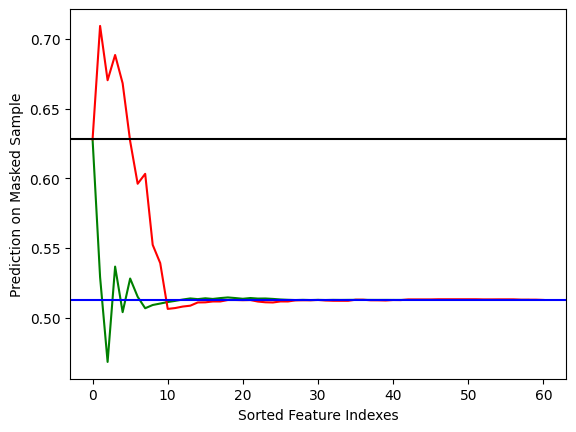

In [55]:
new_predictions_i = []
new_x = x.copy()
new_predictions_i.append(clf.predict(x.reshape(1,-1))[0])
for u in sorted_ss_i_indexes:
    for i in u:
        new_x[i] = means[i]
    new_predictions_i.append(clf.predict(new_x.reshape(1,-1))[0])
new_predictions_i

new_predictions_ks = []
new_x = x.copy()
new_predictions_ks.append(clf.predict(x.reshape(1,-1))[0])
for u in sorted_ks_indexes:

    new_x[u] = means[u]
    new_predictions_ks.append(clf.predict(new_x.reshape(1,-1))[0])
new_predictions_ks

import matplotlib.pyplot as plt
plt.plot(new_predictions_i,color='green')
plt.plot(new_predictions_ks,color='red')
plt.axhline(y = clf.predict(means.reshape(1,-1))[0] , color = 'blue')

plt.axhline(y = clf.predict(x.reshape(1,-1))[0] , color = 'black')
plt.xlabel('Sorted Feature Indexes')
plt.ylabel('Prediction on Masked Sample')
#plt.axvline(x = 8, color = 'green')
#plt.axvline(x = 12, color = 'red')
plt.savefig('correlation_21.pdf')